In [1]:
import pandas as pd
import numpy as np
import aux.acessos as ac
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
query = """

select * from public.flavia_costa_temp_visao_unica
where pc_sow > 0
limit 50000

"""

In [3]:
base = ac.df_athena_q('flavia-costa', query)
base.head()

,id_customer,cpf,ds_safra,idade,ds_schooling,ds_gender,ds_occupation,ds_occupation_reduced,ds_cbo_group,nr_behavior_score,...,fez_pagto_fatura,fez_saque_credito,fez_saque_conta,fez_antecipacao_fatura,limite,score_gh,ds_classificacao_nivel_2,transacoes_hist,flag_ativado,ds_nome_estabelecimento_tratado
0,54255170,04169394062,2021-11,25.0,COMPLETE_HIGH_SCHOOL,MALE,SUPERVISOR DE EMPRESA,GERENTE OU SUPERVISOR DE EMPRESA INDUSTRIAL,"PROFISSIONAIS DAS CIÊNCIAS EXATAS, BIOLÓGICAS,...",NaN,...,1,0,0,0,990.0,18.0,SUPERMERCADO,28,1,COMERCIAL ZAFFARI LOJA
1,f1216957-028e-49a4-8db4-da886caac903,06159692593,2022-01,31.0,COMPLETE_HIGH_SCHOOL,FEMALE,Manicure,MANICURE,"TRABALHADORES DOS SERVIÇOS, VENDEDORES DO COMÉ...",NaN,...,1,0,0,0,360.0,16.0,SUPERMERCADO,31,1,TREVAO COMBUSTIVEIS
2,4311786,04759859586,2019-10,35.0,COMPLETE_HIGH_SCHOOL,FEMALE,ATENDENTE,ATENDENTE,TRABALHADORES DE SERVIÇOS ADMINISTRATIVOS,13.0,...,1,0,0,1,700.0,9.0,VIAGEM,171,1,SHOPEE
3,3394187,93156995215,2017-08,38.0,INCOMPLETE_HIGH_SCHOOL,FEMALE,AUTÔNOMO,AUTONOMO,AUTÔNOMOS,15.0,...,1,0,0,0,NaN,NaN,TELECOM,109,1,RECARGACEL
4,78d40e7d-f5b9-43fa-9338-9e31844c3bc3,63918188515,2022-03,49.0,INCOMPLETE_HIGH_SCHOOL,FEMALE,Autônomo(a),AUTONOMO,AUTÔNOMOS,NaN,...,0,0,0,0,1900.0,18.0,SUPERMERCADO,16,1,LOJAS AMERICANAS


In [4]:
base.columns

Index(['id_customer', 'cpf', 'ds_safra', 'idade', 'ds_schooling', 'ds_gender',
       'ds_occupation', 'ds_occupation_reduced', 'ds_cbo_group',
       'nr_behavior_score', 'pc_sow', 'is_increased_limit', 'fx_atraso_jun22',
       'qtd_if_scr_m1', 'qtd_if_scr_current', 'pf_top_mcc', 'renda_declarada',
       'spending90dias', 'transacoes90dias', 'spending_ultimo_ano',
       'transacoes_ultimo_ano', 'fez_ted_cash_in', 'fez_ted_cash_out',
       'fez_deposito_cred_boleto', 'recebeu_pix', 'fez_pix_conta',
       'fez_pix_credito', 'fez_pgto_titulo', 'fez_pagto_fatura',
       'fez_saque_credito', 'fez_saque_conta', 'fez_antecipacao_fatura',
       'limite', 'score_gh', 'ds_classificacao_nivel_2', 'transacoes_hist',
       'flag_ativado', 'ds_nome_estabelecimento_tratado'],
      dtype='object')

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 5
features_cluster = ['limite', 'transacoes_hist', 'score_gh', 'pc_sow']
base_cluster = base[features_cluster]
for i in base_cluster.columns:
    base_cluster[i] = base_cluster[i].fillna(0.0)
scaler = StandardScaler()
scaler_model = scaler.fit(base_cluster)
data_input_scaled = scaler_model.transform(base_cluster)
kmeans = KMeans(n_clusters = k, random_state=0).fit(data_input_scaled)
cluster = kmeans.predict(data_input_scaled)
base_cluster['cluster'] = cluster
base['cluster'] = cluster

print("---------------VOLUMETRIA ------------------")
print(base['cluster'].value_counts())
print(base['cluster'].value_counts(normalize = True))
print("---------------SILHOUETTE SCORE ------------")
print(silhouette_score(base_cluster[features_cluster], base_cluster['cluster']))



/tmp/ipykernel_123043/4108140218.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster[i] = base_cluster[i].fillna(0.0)
/tmp/ipykernel_123043/4108140218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster['cluster'] = cluster


---------------VOLUMETRIA ------------------
2    20259
1    12736
3     7484
0     6886
4     2635
Name: cluster, dtype: int64
2    0.40518
1    0.25472
3    0.14968
0    0.13772
4    0.05270
Name: cluster, dtype: float64
---------------SILHOUETTE SCORE ------------
0.02433560595177785


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(base_cluster[features_cluster]
                                                    , base_cluster['cluster']
                                                    , random_state=42, test_size=0.20)
arvores = [20, 50, 100, 300, 400, 500]
accuracy_array = []

for i in arvores:
  rf = RandomForestClassifier(n_estimators=i)
  rf.fit(x_train, y_train)
  y_predicted_rf = rf.predict(x_test)
  accuracy_rf = accuracy_score(y_test, y_predicted_rf).round(4)
  accuracy_array.append(accuracy_rf)
rf_estimators = pd.DataFrame(list(zip(arvores, accuracy_array)), columns =['arvores', 'acuracia'])
print("---------------ACURACCY CLASSIFICATION ------------")
rf_estimators['acuracia'].max()

0.9881

---------------IMPORTANCIA DAS FEATURES ------------


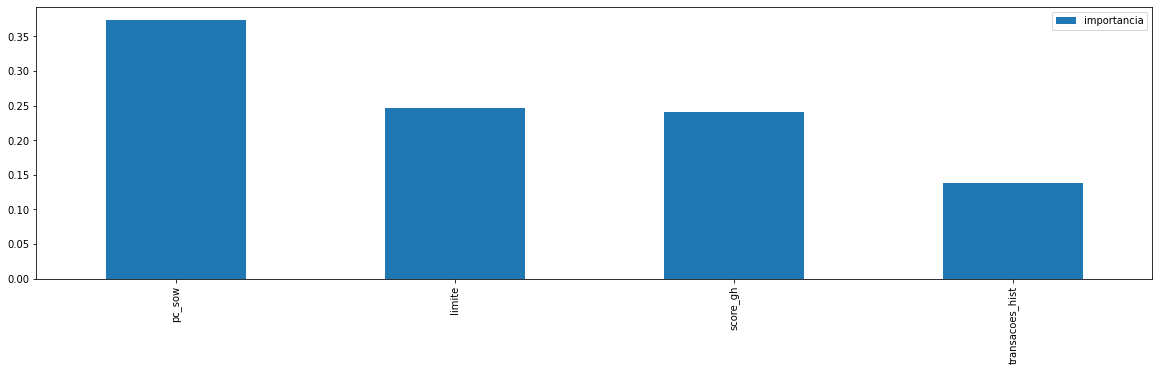

In [32]:
print("---------------IMPORTANCIA DAS FEATURES - O QUE MAIS PESOU NA CONSTRUÇÃO DOS GRUPOS? ------------")
best_rf = RandomForestClassifier(n_estimators= rf_estimators['arvores'][rf_estimators['acuracia'].idxmax()])
best_rf.fit(x_train, y_train)
importance_df = pd.DataFrame(best_rf.feature_importances_, columns = ['importancia'], index = features_cluster)
importance_df.sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))
features_importantes = importance_df.sort_values(by='importancia', ascending=False).head(20).index

In [22]:
print("---------------MEDIAS POR CLUSTER ------------")
cl_col = ['cluster']
totalfeat = features_cluster + cl_col
base[totalfeat].groupby('cluster').mean()


---------------MEDIAS POR CLUSTER ------------


,limite,transacoes_hist,score_gh,pc_sow
cluster,,,,
0,2269.172960,57.600058,18.818738,0.383065
1,796.932318,88.665122,13.700919,0.840533
2,655.487388,55.684585,14.294092,0.202271
3,686.557968,151.567344,6.298006,0.475001
4,953.131994,605.800000,10.117347,0.624813


In [25]:
print("---------------PERCENTIS POR CLUSTER  - P25 ------------")
base[totalfeat].groupby('cluster').quantile(0.25)

---------------PERCENTIS POR CLUSTER ------------


,limite,transacoes_hist,score_gh,pc_sow
cluster,,,,
0,1800.0,13.0,19.0,0.169860
1,540.0,26.0,11.0,0.682961
2,100.0,14.0,12.0,0.075157
3,500.0,63.0,6.0,0.220252
4,700.0,443.0,8.0,0.388997


In [26]:
print("---------------PERCENTIS POR CLUSTER  - P50 ------------")
base[totalfeat].groupby('cluster').quantile(0.50)

---------------PERCENTIS POR CLUSTER  - P50 ------------


,limite,transacoes_hist,score_gh,pc_sow
cluster,,,,
0,2250.0,31.0,19.0,0.349850
1,800.0,59.0,14.0,0.891443
2,700.0,33.0,15.0,0.177647
3,600.0,133.0,7.0,0.439144
4,800.0,527.0,10.0,0.643566


In [27]:
print("---------------PERCENTIS POR CLUSTER  - P75 ------------")
base[totalfeat].groupby('cluster').quantile(0.75)

---------------PERCENTIS POR CLUSTER  - P75 ------------


,limite,transacoes_hist,score_gh,pc_sow
cluster,,,,
0,2540.0,71.75,20.0,0.545909
1,1000.0,127.00,17.0,1.000000
2,950.0,72.00,17.0,0.313077
3,800.0,228.00,7.0,0.702565
4,1200.0,674.00,12.0,0.905732


In [87]:
#binarizar e gerar tabela com proporções
for i in features_cluster:
    base_cluster[i + '_bin'] = pd.qcut(base_cluster[i], 5, labels=False)
    print(base_cluster.groupby(base_cluster[i + '_bin']).agg({i: ['min', 'max']}))


            limite         
               min      max
limite_bin                 
0              0.0    100.0
1            120.0    600.0
2            610.0    880.0
3            890.0   1320.0
4           1330.0  10395.0
                    transacoes_hist      
                                min   max
transacoes_hist_bin                      
0                                 0    16
1                                17    36
2                                37    74
3                                75   162
4                               163  2904
             score_gh      
                  min   max
score_gh_bin               
0                 0.0   7.0
1                 8.0  12.0
2                13.0  16.0
3                17.0  18.0
4                19.0  20.0
                  pc_sow          
                     min       max
pc_sow_bin                        
0           8.577793e-07  0.122412
1           1.224223e-01  0.286026
2           2.860579e-01  0.502722
3     

/tmp/ipykernel_123043/1589157383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster[i + '_bin'] = pd.qcut(base_cluster[i], 5, labels=False)
/tmp/ipykernel_123043/1589157383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster[i + '_bin'] = pd.qcut(base_cluster[i], 5, labels=False)
/tmp/ipykernel_123043/1589157383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [283]:
#!pip install statsmodels

In [282]:
k = 5

print("---------------DETECTAR PROPORÇÕES SIMILARES ENTRE OS CLUSTERS ------------")

from statsmodels.stats.proportion import proportions_ztest

for cl1 in range(k-1):
    
    for cl2 in range(k-1):
         
        for vr in features_cluster:
            var_fx = vr + '_bin'
            j = base_cluster[var_fx].unique()
            for faixa in j:
                b1 = base_cluster[base_cluster['cluster'] == cl1]
                n1 = len(b1)
                p1 = len(b1[b1[var_fx] == faixa])
                b2 = base_cluster[base_cluster['cluster'] == cl2]
                n2 = len(b2)
                p2 = len(b2[b2[var_fx] == faixa])
                number_sucesses = np.array([p1, p2])
                sample_sizes = np.array([n1, n2])
                stat, pval = proportions_ztest(number_sucesses, sample_sizes)
                
                if pval > 0.05 and cl1 != cl2:
                    print("associação do cluster " + str(cl1) + " e do " + str(cl2))
                    print(" p-valor: ")
                    print('{0:0.3f}'.format(pval))
                    print("para a faixa " + str(faixa) + " da variavel " + str(vr))
                    print("______________________________________________________________")



/home/flavia.costa/.local/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


associação do cluster 1 e do 2
 p-valor: 
0.969
para a faixa 2 da variavel transacoes_hist
______________________________________________________________
associação do cluster 2 e do 1
 p-valor: 
0.969
para a faixa 2 da variavel transacoes_hist
______________________________________________________________


In [284]:
#caso tenha outras variáveis em faixas renomear para "_bin"
tabela_valid = pd.DataFrame()

for i in features_cluster:
    group_var = i  + "_bin" #faixas de features que quero cruzar com o cluster
    x_var = 'cluster'
    agg = base_cluster.groupby([x_var, group_var]).agg({'cluster':['count']})
    agg.columns = agg.columns.droplevel(0)
    agg = agg.reset_index()
    agg = agg.pivot_table(columns=x_var,index = group_var, values='count', aggfunc=np.sum)
    for i in agg.columns:
        agg[i] = agg[i] / agg[i].sum()
      
    agg = agg.fillna(0.0)
    agg['feature'] = group_var
    tabela_valid = tabela_valid.append(agg)

tabela_valid = tabela_valid.reset_index()
print("--------------------TABELA DE PROPORÇÕES --------------------")
tabela_valid.head(20)
print("______________________________________________________________")


/tmp/ipykernel_123043/4683897.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabela_valid = tabela_valid.append(agg)
/tmp/ipykernel_123043/4683897.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabela_valid = tabela_valid.append(agg)
/tmp/ipykernel_123043/4683897.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabela_valid = tabela_valid.append(agg)
/tmp/ipykernel_123043/4683897.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tabela_valid = tabela_valid.append(agg)


cluster,index,0,1,2,3,4,feature
0,0,0.000000,0.100031,0.250160,0.699492,0.470968,limite_bin
1,1,0.000000,0.242855,0.214917,0.171432,0.126376,limite_bin
2,2,0.000000,0.279366,0.224493,0.076029,0.173814,limite_bin
3,3,0.010456,0.261542,0.244336,0.035810,0.141935,limite_bin
4,4,0.989544,0.116206,0.066094,0.017237,0.086907,limite_bin
5,0,0.315568,0.156407,0.283528,0.070818,0.000000,transacoes_hist_bin
6,1,0.235841,0.193624,0.249914,0.075628,0.000000,transacoes_hist_bin
7,2,0.212170,0.227073,0.227257,0.144842,0.000000,transacoes_hist_bin
8,3,0.155533,0.251021,0.165902,0.295029,0.000000,transacoes_hist_bin
9,4,0.080889,0.171875,0.073399,0.413683,1.000000,transacoes_hist_bin


In [288]:
print("---------------CARACTERÍSTICAS MUITO DOMINANTES ------------")
cont_caract = 0
n = 0

for i in tabela_valid.columns:
    if tabela_valid[i].dtype == "float":
        cont_caract +=  sum(tabela_valid[i] >= 0.5)
        n += len(tabela_valid[i])
         

print(cont_caract)
print(round(cont_caract / n, 2))

---------------CARACTERÍSTICAS DOMINANTES ------------
7
0.07


In [285]:
corr = tabela_valid.corr(method='pearson')

x = 0

for column in corr.columns:
    if column != 'index' and column != 'cluster':
        corr_temp = corr[corr[column] != 1]
        corr_temp = corr_temp[abs(corr_temp[column]) > 0.70]
        x = x + len(corr_temp[column])
print("---------------CLUSTERS COM ALTA CORRELAÇÃO ------------")
print(x)

---------------CLUSTERS COM ALTA CORRELAÇÃO ------------
0


In [262]:
corr.head(10)

cluster,index,0,1,2,3,4
cluster,,,,,,
index,1.000000,0.404733,0.404437,-0.559053,-0.358619,0.080741
0,0.404733,1.000000,-0.327130,-0.289315,-0.343396,-0.336249
1,0.404437,-0.327130,1.000000,-0.299032,-0.248291,0.037047
2,-0.559053,-0.289315,-0.299032,1.000000,-0.303404,-0.438108
3,-0.358619,-0.343396,-0.248291,-0.303404,1.000000,0.668829
4,0.080741,-0.336249,0.037047,-0.438108,0.668829,1.000000
